In [42]:
import matplotlib.pyplot as plt
from skimage import io
import pandas
import os
import sys
from textwrap import wrap

sys.path.insert(0, os.path.join(os.path.split(os.getcwd())[0], "classes"))
from Parameters import Parameters

## Montage kymographs

#### Usage
* Make a new folder with the experiment (or comparison) title as its name. 
* Put the (dated) output folders from analyses of interest into the experiment folder
* Write the path to the folder in the "experiment folder" variable immediately below, taking care to use \\\ to separate folders
* Output figures can be saved by right clicking on the figure and saving as a PNG to the local machine

C:\Users\dougk\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2128: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


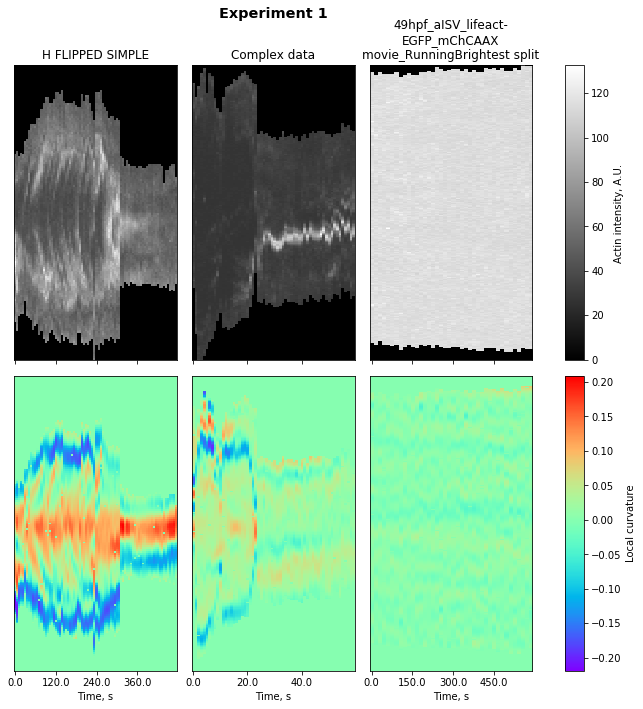

In [43]:
experiment_folder = "D:\\data\\Inverse blebbing\\Experiment 1"

# load and plot kymographs
plt.rc('text',usetex=False)
actin_kyms = []; 
curvature_kyms = [];
paramses = [];
subtitles = [];
experiment_title = os.path.basename(experiment_folder);
for idx, subfolder in enumerate(os.listdir(experiment_folder)):
    actin_kyms.append(io.imread(os.path.join(experiment_folder, subfolder, "normalised position Actin kymograph.tif")));
    curvature_kyms.append(io.imread(os.path.join(experiment_folder, subfolder, "normalised position curvature kymograph.tif")));
    params = Parameters();
    params.loadParametersFromJson(os.path.join(experiment_folder, subfolder, "parameters used.json"));
    paramses.append(params);
    subtitles.append(os.path.splitext(os.path.basename(params.input_image_path))[0])
curv_lims = (min([im.min() for im in curvature_kyms]), max([im.max() for im in curvature_kyms]));
fig, axs = plt.subplots(ncols=len(actin_kyms), nrows=2, sharex='col', figsize=(3*len(curvature_kyms),10));
for idx in range(len(actin_kyms)):
    im1=axs[0][idx].imshow(actin_kyms[idx], plt.cm.gray, aspect='auto', interpolation=None);
    im2=axs[1][idx].imshow(curvature_kyms[idx], plt.cm.rainbow, vmin=curv_lims[0], vmax=curv_lims[1], aspect='auto', interpolation=None);
    axs[1][idx].set_xlabel("Time, s");
    axs[0][idx].set_yticks([]);
    axs[1][idx].set_yticks([]);

# handle presentation
plt.tight_layout()
fig.subplots_adjust(top=0.90, right=0.9, left=0.1);
cbar_ax1 = fig.add_axes([0.95, axs[0][2].get_position().y0, 0.03, (axs[0][2].get_position().y1 - axs[0][2].get_position().y0)])
cbar_ax2 = fig.add_axes([0.95, axs[1][2].get_position().y0, 0.03, (axs[1][2].get_position().y1 - axs[1][2].get_position().y0)])
fig.colorbar(im1, cax=cbar_ax1);
fig.colorbar(im2, cax=cbar_ax2);
cbar_ax1.set_ylabel("Actin intensity, A.U. ");
cbar_ax2.set_ylabel("Local curvature");

for idx in range(len(actin_kyms)):
    lbls = axs[1][idx].get_xticklabels()
    newlbls = ([(paramses[idx].frame_interval * float(l.get_text().replace("−","-"))) for l in lbls]);
    axs[1][idx].set_xticklabels(newlbls);
    axs[0][idx].set_title("\n".join(wrap(subtitles[idx], 30)));

plt.rc('figure', titlesize='x-large', titleweight='bold')
fig.suptitle(experiment_title)
plt.show();